## Trabajo Práctico 2: Entrenamiento y evaluación de modelos

### Reservas de hotel - Grupo 4 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn_pandas
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn_pandas import DataFrameMapper
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')

### Métrica

La métrica que utilizaremos es **Precision**, ya que en este caso, el impacto de errar por si o por no, es diferente. Esto quiere decir que necesitamos saber de las reservas clasificadas como canceladas, que porcentaje realmente son canceladas. Además elegimos ésta métrica porque nuestra variable de salida está desbalanceada (33% reservas canceladas, 77% reservas no canceladas), eso quiere decir que utilizando otras métricas para evaluar nuestro modelo, podría generar problemas. Por ejemplo si utilizamos la métrica Accuracy, la cuál es una de las más usadas y sencillas para explicarle al usuario final, no tiene en cuenta el desbalance de la variable a predecir, por lo tanto, se generaría una evaluación engañosa del modelo, es decir, se estaría prediciendo correctamente reservas que no se cancelaron, pero no estaría prediciendo correctamente reservas que si se cancelaron. 
Hay que tener en cuenta que al tener solamente la métrica de Precision, podría ser engañoso ya que, si el modelo dice muy pocas veces que la reserva es cancelada ('booking_status' = 1) y acierta, la métrica devuelve un valor alto, a pesar de que no es útil ésta evaluación. También decidimos utilizar **Recall** para saber que porcentaje de casos positivos es capaz de detectar y asegurarnos de que no haya falsos negativos, además incluimos **F-Score** ya que combina Precision y Recall. 


### Preprocesamiento de datos

Aplicamos las transformaciones al dataset que definimos en la entrega pasada: 
- Convertir la variable target a bool.
- No se hará limpieza de valores nulos ya que no hay en el dataset. 
- Eliminar los datos que no se utilizarán.

In [2]:
data = pd.read_csv('Hotel Reservations.csv')

# Eliminamos la columna "Booking_ID" ya que podría generar overfitting.
data.drop('Booking_ID', axis=1, inplace=True)
# Reemplazamos los valores 'Canceled' y 'Not_Canceled' por 1 y 0 de la variable target.
data["booking_status"] = data.booking_status.replace(['Canceled','Not_Canceled'],[1,0])

In [3]:
# Dividimos el dataset en train (60%), test (20%) y validation (20%)
train, not_train = train_test_split(data, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train.shape, validation.shape, test.shape

((21765, 18), (7255, 18), (7255, 18))

#### DataFrameMapper

Transformers a utilizar: 

- Escalar todas las variables numéricas que no sean booleanas con MinMaxEscaler. 

- Para las variables booleanas se utiliza OneHotEncoder. 





In [4]:
# Escalamos las variables numéricas y aplicamos OneHotEncoder a las variables categoricas. 
#Definimos el mapper que recibe una lista (columna, transformador)
mapper = DataFrameMapper([
    (['no_of_adults'],[MinMaxScaler()]),
    (['no_of_children'],[MinMaxScaler()]),
    (['no_of_weekend_nights'],[MinMaxScaler()]),
    (['no_of_week_nights'],[MinMaxScaler()]),
    (['type_of_meal_plan'],[OneHotEncoder()]),
    (['required_car_parking_space'],None),
    (['room_type_reserved'],[OneHotEncoder()]),
    (['lead_time'],[MinMaxScaler()]),
    (['arrival_year'],[MinMaxScaler()]),
    (['arrival_month'],[MinMaxScaler()]),
    (['arrival_date'],[MinMaxScaler()]),
    (['market_segment_type'],[OneHotEncoder()]),
    (['repeated_guest'],None),
    (['no_of_previous_cancellations'],[MinMaxScaler()]),
    (['no_of_previous_bookings_not_canceled'],[MinMaxScaler()]),
    (['avg_price_per_room'],[MinMaxScaler()]),
    (['no_of_special_requests'],[MinMaxScaler()])
])

#Lo enrenamos con train
mapper.fit(train)

DataFrameMapper(drop_cols=[],
                features=[(['no_of_adults'], [MinMaxScaler()]),
                          (['no_of_children'], [MinMaxScaler()]),
                          (['no_of_weekend_nights'], [MinMaxScaler()]),
                          (['no_of_week_nights'], [MinMaxScaler()]),
                          (['type_of_meal_plan'], [OneHotEncoder()]),
                          (['required_car_parking_space'], None),
                          (['room_type_reserved'], [OneHotEncoder()]),
                          (['lead_time'], [MinMaxScaler(...
                          (['arrival_year'], [MinMaxScaler()]),
                          (['arrival_month'], [MinMaxScaler()]),
                          (['arrival_date'], [MinMaxScaler()]),
                          (['market_segment_type'], [OneHotEncoder()]),
                          (['repeated_guest'], None),
                          (['no_of_previous_cancellations'], [MinMaxScaler()]),
                          (['no_of_previous_bookings_not_canceled'],
                           [MinMaxScaler()]),
                          (['avg_price_per_room'], [MinMaxScaler()]),
                          (['no_of_special_requests'], [MinMaxScaler()])])

In [5]:
sample = train.sample(5, random_state=42)
sample

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
15720,2,0,2,5,Meal Plan 1,0,Room_Type 1,88,2017,10,31,Online,0,0,0,54.63,0,0
23899,1,0,0,3,Meal Plan 1,0,Room_Type 1,68,2018,5,10,Online,0,0,0,121.50,0,1
10213,1,0,1,1,Meal Plan 1,0,Room_Type 1,33,2018,1,25,Complementary,0,0,0,1.00,0,0
24938,2,0,0,3,Meal Plan 1,0,Room_Type 1,160,2017,12,30,Offline,0,0,0,70.67,0,0
10678,2,0,0,3,Meal Plan 1,0,Room_Type 1,304,2018,11,3,Offline,0,0,0,89.00,0,1


In [6]:
# Sample transformado
mapper.transform(sample)

array([[0.5       , 0.        , 0.33333333, 0.29411765, 1.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.1986456 , 0.        , 0.81818182, 1.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.14548602, 0.        ],
       [0.25      , 0.        , 0.        , 0.17647059, 1.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.15349887, 1.        , 0.36363636, 0.3       ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.32356858, 0.        ],
       [0.25      , 0.        , 0.16666667, 0.05882353, 1.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.

In [7]:
# Nombres de las columnas
mapper.transformed_names_

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'type_of_meal_plan_0',
 'type_of_meal_plan_1',
 'type_of_meal_plan_2',
 'type_of_meal_plan_3',
 'required_car_parking_space',
 'room_type_reserved_0',
 'room_type_reserved_1',
 'room_type_reserved_2',
 'room_type_reserved_3',
 'room_type_reserved_4',
 'room_type_reserved_5',
 'room_type_reserved_6',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'market_segment_type_0',
 'market_segment_type_1',
 'market_segment_type_2',
 'market_segment_type_3',
 'market_segment_type_4',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests']

### Feature Engineering

Aplicar una tecnica de FE y comparar con lo anterior (FALTA ESTO).

Para nuestro dataset decidimos crear una nueva feature 'season' a partir de las columnas 'arrival_date' y 'arrival_month' para determinar a que estación del año pertenece dicha reserva, y verificar si es útil para mejorar las predicciones del modelo.
En nuestro caso vamos a categorizar las estaciones en season_1, season_2, season_3 y season_4, tomamos estos valores ya que no sabemos en que hemisferio esta ubicado el hotel para determinar las estaciones correctamente.
<br>
Como la nueva feature es categorica, vamos a aplicarle OneHotEncoder para generar una nueva columna por cada posible valor.



In [8]:
#Función que devuelve la estación a la que pertenece una reserva.
def get_season(row):
    if (row['arrival_month'] >= 1 and row['arrival_month'] <=3):
        if (row['arrival_month'] == 3 and row['arrival_date'] >= 21):
            return 'season_2'
        else:
            return 'season_1'
    elif (row['arrival_month'] >= 4 and row['arrival_month'] <=6):
        if (row['arrival_month'] == 6 and row['arrival_date'] >= 21):
            return 'season_3'
        else:
            return 'season_2'
    elif (row['arrival_month'] >= 7 and row['arrival_month'] <=9):
        if (row['arrival_month'] == 9 and row['arrival_date'] >= 21):
            return 'season_4'
        else:
            return 'season_3'
    elif (row['arrival_month'] >= 10 and row['arrival_month'] <=12):
        if (row['arrival_month'] == 12 and row['arrival_date'] >= 21):
            return 'season_1'
        else:
            return 'season_4'
        
#Se agrega la nueva columna al dataset
season = data.apply(get_season,axis=1)
data_fe = data
data_fe['season'] = season

data_fe


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,season
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,0,season_4
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,0,season_4
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,1,season_1
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,1,season_2
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,1,season_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,0,season_3
36271,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,1,season_4
36272,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,0,season_3
36273,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,1,season_2


In [9]:
# Dividimos el dataset en train (60%), test (20%) y validation (20%)
train_fe, not_train_fe = train_test_split(data_fe, test_size=0.4, random_state=42)
validation_fe, test_fe = train_test_split(not_train_fe, test_size=0.5, random_state=42)

In [10]:
# Escalamos las variables numéricas y aplicamos OneHotEncoder a las variables categoricas. 
#Definimos el mapper que recibe una lista (columna, transformador)
mapper_fe = DataFrameMapper([
    (['no_of_adults'],[MinMaxScaler()]),
    (['no_of_children'],[MinMaxScaler()]),
    (['no_of_weekend_nights'],[MinMaxScaler()]),
    (['no_of_week_nights'],[MinMaxScaler()]),
    (['type_of_meal_plan'],[OneHotEncoder()]),
    (['required_car_parking_space'],None),
    (['room_type_reserved'],[OneHotEncoder()]),
    (['lead_time'],[MinMaxScaler()]),
    (['arrival_year'],[MinMaxScaler()]),
    (['arrival_month'],[MinMaxScaler()]),
    (['arrival_date'],[MinMaxScaler()]),
    (['market_segment_type'],[OneHotEncoder()]),
    (['repeated_guest'],None),
    (['no_of_previous_cancellations'],[MinMaxScaler()]),
    (['no_of_previous_bookings_not_canceled'],[MinMaxScaler()]),
    (['avg_price_per_room'],[MinMaxScaler()]),
    (['no_of_special_requests'],[MinMaxScaler()]),
    (['season'],[OneHotEncoder()])
])

#Lo enrenamos con train
mapper_fe.fit(train_fe)

DataFrameMapper(drop_cols=[],
                features=[(['no_of_adults'], [MinMaxScaler()]),
                          (['no_of_children'], [MinMaxScaler()]),
                          (['no_of_weekend_nights'], [MinMaxScaler()]),
                          (['no_of_week_nights'], [MinMaxScaler()]),
                          (['type_of_meal_plan'], [OneHotEncoder()]),
                          (['required_car_parking_space'], None),
                          (['room_type_reserved'], [OneHotEncoder()]),
                          (['lead_time'], [MinMaxScaler(...
                          (['arrival_month'], [MinMaxScaler()]),
                          (['arrival_date'], [MinMaxScaler()]),
                          (['market_segment_type'], [OneHotEncoder()]),
                          (['repeated_guest'], None),
                          (['no_of_previous_cancellations'], [MinMaxScaler()]),
                          (['no_of_previous_bookings_not_canceled'],
                           [MinMaxScaler()]),
                          (['avg_price_per_room'], [MinMaxScaler()]),
                          (['no_of_special_requests'], [MinMaxScaler()]),
                          (['season'], [OneHotEncoder()])])

### Entrenamiento y evaluación de modelos

Se entrenarán los siguientes modelos: 

- Logistic Regression
- Decision Trees (árboles de decisión)
- Random Forest


In [11]:
#Función para evaluar modelos SIN feature engineering
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=True):
    if title:
        display(title)
        
    final_metrics = defaultdict(list)
    
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]

        y = set_data.booking_status
        y_pred = model.predict(set_data)
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['Cancelada', 'No Cancelada'])
            ax.yaxis.set_ticklabels(['Cancelada', 'No Cancelada'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()



In [12]:
#Función para evaluar modelos CON feature engineering
def evaluate_model_fe(model, set_names=('train_fe', 'validation_fe'), title='', show_cm=True):
    if title:
        display(title)
        
    final_metrics = defaultdict(list)
    
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train_fe', 'validation_fe', 'test_fe']
        set_data = globals()[set_name]

        y = set_data.booking_status
        y_pred = model.predict(set_data)
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['Cancelada', 'No Cancelada'])
            ax.yaxis.set_ticklabels(['Cancelada', 'No Cancelada'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

### 1. Regresión Logística

- ### Parámetros por defecto.

'Regresión Logistica con valor por default'

,Precision,Recall,F1
train,0.735617,0.62161,0.673825
validation,0.753432,0.60801,0.672954


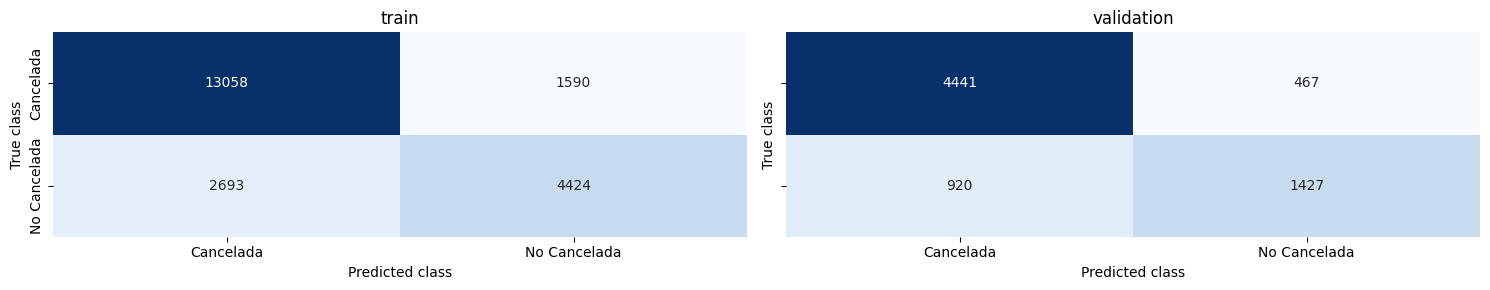

In [13]:
regression_model = LogisticRegression(random_state=42)
lr_model = Pipeline([
    ('mapper', mapper),
    ('classifier', regression_model)
])

lr_model.fit(train, train.booking_status)
evaluate_model(lr_model, title='Regresión Logistica con valor por default')

In [14]:
print('Cantidad de iteraciones:', regression_model.max_iter)

Cantidad de iteraciones: 100


### Técnica para optimizar resultados: 
- ### Definiendo hiperparámetros:

Se limita la **cantidad de iteraciones** que el algoritmo puede realizar. 

'Regresión Logística - max_iter = 13'

,Precision,Recall,F1
train,0.745806,0.612196,0.672428
validation,0.767965,0.596506,0.671463


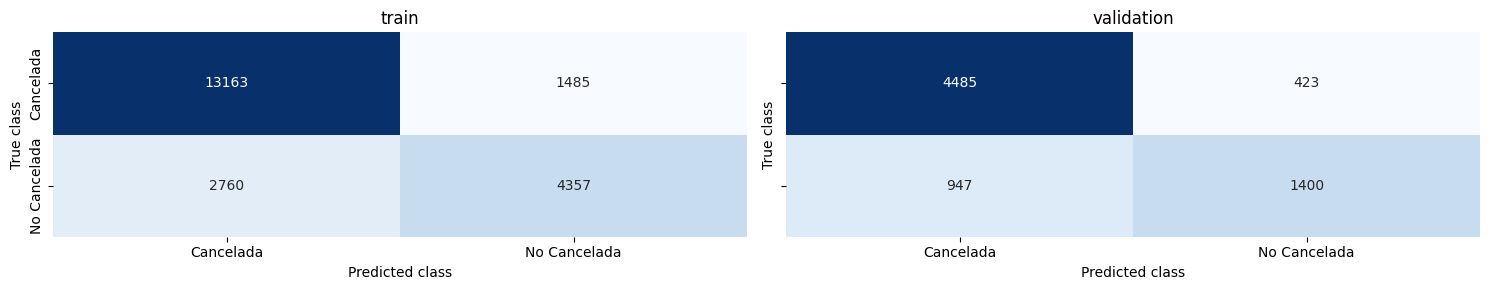

In [15]:
regression_model_max_iter = LogisticRegression(max_iter=13, random_state=42)
lr_model = Pipeline([
    ('mapper', mapper),
    ('classifier', regression_model_max_iter)
])

lr_model.fit(train, train.booking_status)
evaluate_model(lr_model, title='Regresión Logística - max_iter = 13')

Se puede observar que la métrica Precision mejora un poco y la métrica Recall baja un poco. Si limitamos la cantidad de iteraciones con valores cada vez más chicos, el algoritmo converge antes, se mantiene la métrica Precision, pero el Recall baja cada vez más porque el modelo no llega a detectar bien cada clase. 

**Under-Sampling**: Se realiza un **balanceo** de la clase minoritaria "Canceladas" y mayoritaria "No canceladas". En este caso, el modelo está sesgado hacia la clase mayoritaria, así que lo que haremos será utilizar el parámetro **class_weight** para asignar pesos distintos a los errores cometidos. 

In [16]:
#Observamos los pesos que aprendió la Regresión Logística
clf = lr_model.named_steps['classifier']
clf.coef_ 

array([[ 6.81987123e-01,  1.55967313e-01,  4.63478066e-01,
         2.88070712e-01, -8.07047823e-01, -1.99349225e-01,
         3.13375074e-02, -7.19971227e-01, -1.60813093e+00,
        -2.53143918e-01, -8.80487164e-01,  9.26146288e-04,
        -3.06286147e-01, -1.95904387e-01,  4.17741623e-02,
        -1.01909460e-01,  6.42689708e+00,  5.58572183e-01,
        -4.06599390e-01, -7.64595983e-02,  1.74746147e-01,
        -9.56618764e-01, -1.66201887e-01, -1.35883082e+00,
         6.11874558e-01, -1.39644208e+00, -6.76387937e-03,
        -1.48574658e-01,  3.00319236e+00, -7.40487301e+00]])

In [17]:
mapper.transformed_names_

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'type_of_meal_plan_0',
 'type_of_meal_plan_1',
 'type_of_meal_plan_2',
 'type_of_meal_plan_3',
 'required_car_parking_space',
 'room_type_reserved_0',
 'room_type_reserved_1',
 'room_type_reserved_2',
 'room_type_reserved_3',
 'room_type_reserved_4',
 'room_type_reserved_5',
 'room_type_reserved_6',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'market_segment_type_0',
 'market_segment_type_1',
 'market_segment_type_2',
 'market_segment_type_3',
 'market_segment_type_4',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests']

'Regresión Lineal - class_weight balanced'

,Precision,Recall,F1
train,0.640028,0.771954,0.699828
validation,0.652379,0.765232,0.704314


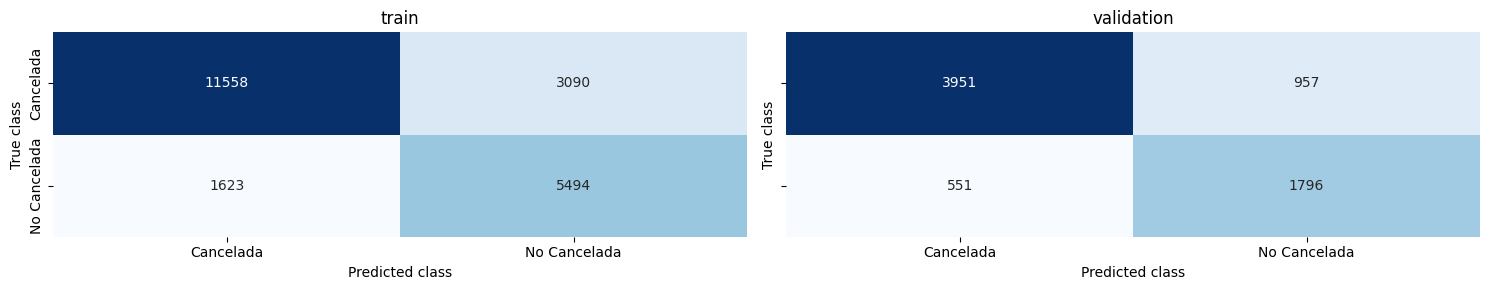

In [18]:
regression_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_model = Pipeline([
    ('mapper', mapper),
    ('classifier', regression_model),
])

lr_model.fit(train, train.booking_status)
evaluate_model(lr_model, title='Regresión Lineal - class_weight balanced')

In [19]:
clf = lr_model.named_steps['classifier']
clf.coef_ 

array([[ 0.38290881,  0.95009753,  0.89089652,  0.50741143, -0.63926516,
        -0.39635851,  0.37982448, -0.45193706, -1.6862063 ,  0.24632944,
        -0.16187144,  0.16429427,  0.00909434, -0.13587594, -0.45887035,
        -0.77083657,  6.87697688,  0.38866135, -0.4022227 ,  0.09423897,
         0.67468495, -1.77523198,  0.07284667, -0.93754436,  0.85750847,
        -2.02418569,  1.47822074, -0.28964396,  5.91641803, -7.1351766 ]])

Como se puede observar la métrica Recall y F1 mejoran, pero Precision baja. Esto quiere decir que el modelo detecta un poco mejor cada clase, pero incluye muestras de la otra clase. Por ejemplo, detecta reservas "Canceladas" como "No canceladas". 

### 2. Árboles de Decisión

- ### Parámetros por defecto

'Decision Tree'

,Precision,Recall,F1
train,0.995748,0.987214,0.991463
validation,0.795242,0.797614,0.796426


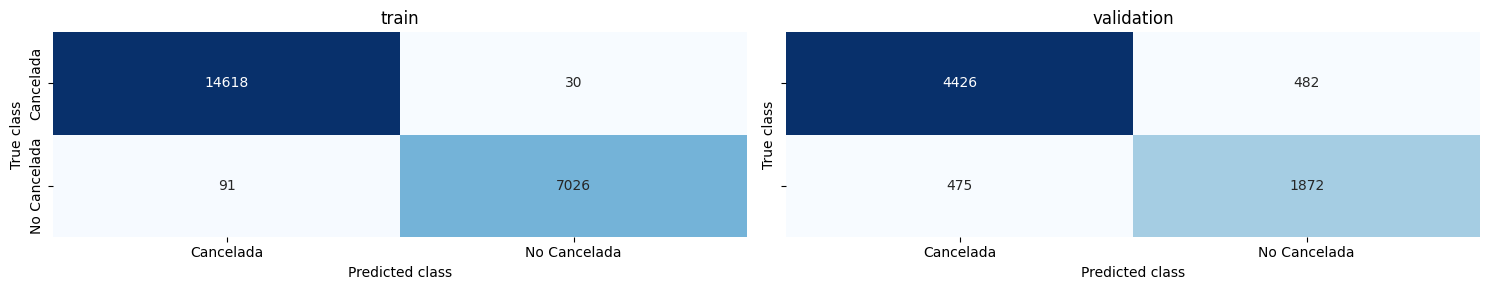

In [20]:
tree_model = DecisionTreeClassifier(random_state=42)

dt_model = Pipeline([
    ('mapper', mapper),
    ('classifier', tree_model),
])

dt_model.fit(train, train.booking_status)

evaluate_model(dt_model, title='Decision Tree')

In [21]:
print('Cantidad de nodos:', tree_model.tree_.node_count)
print('Profundidad máxima:', tree_model.tree_.max_depth)

Cantidad de nodos: 5247
Profundidad máxima: 36


Se puede observar que el resultado del entrenamiento para Train es un overfitting, las métricas alcanzan un 99%. Al no definir una profundidad máxima para el árbol, éste hace muchos cortes, por lo tanto, va a tener muchas hojas y cada hoja tiene pocos casos incluidos, es decir, se memoriza casos de ejemplo y cada rama es un ejemplo. 
Podemos observar que la profundidad máxima para el árbol es 36 y la cantidad de nodos es 5247. 

### Técnica para evitar overfitting en el modelo: 
- ### Definiendo hiperparámetros

Con **Grid Search** podemos obtener los valores óptimos de los hiperparámetros referidos a la profundidad máxima del árbol y el número mínimo de observaciones que debe tener una hoja para seguir creando nuevos nodos.

In [22]:
parameters = {'max_depth':[3, 5, 8, 11, 13, 15, 18, 23, 25, 28], 'min_samples_split':[2,3,4,5]}

clf = GridSearchCV(tree_model, parameters, refit=True, verbose=1)

gs_pipe = Pipeline([
    ('mapper', mapper),
    ('classifier', clf),
])

gs_pipe.fit(train, train.booking_status)

clf.best_score_, clf.best_params_



Fitting 5 folds for each of 40 candidates, totalling 200 fits


(0.8743854812772801, {'max_depth': 11, 'min_samples_split': 2})

#### Límite de profundidad = 11 y número mínimo de observaciones que debe tener una hoja para seguir creando nodos = 2

'Decision Tree con limite de profundidad = 11'

,Precision,Recall,F1
train,0.862217,0.818603,0.839844
validation,0.852352,0.779719,0.814419


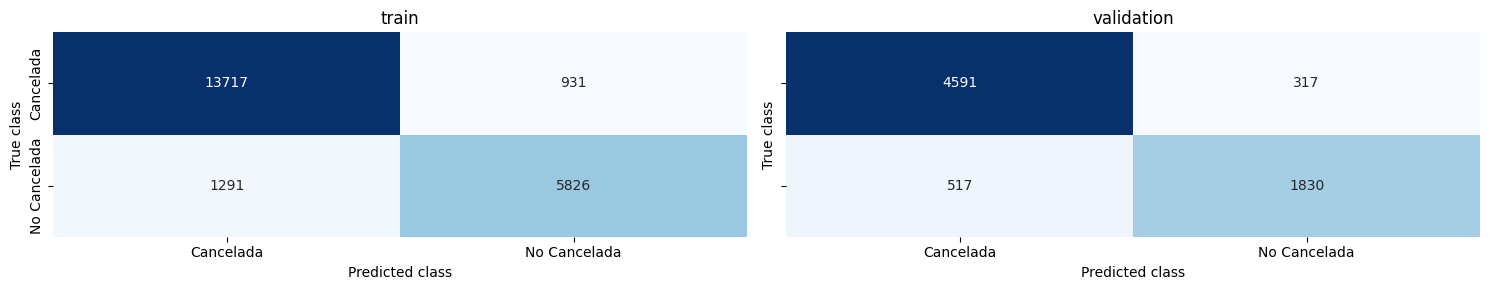

In [23]:
max_depth_value = 11
min_samples_split_value = 2
tree_model = DecisionTreeClassifier(max_depth=max_depth_value, min_samples_split=min_samples_split_value, random_state=42)

dt_model = Pipeline([
    ('mapper', mapper),
    ('classifier', tree_model),
])

dt_model.fit(train, train.booking_status)

evaluate_model(dt_model, title='Decision Tree con limite de profundidad = 11')

In [24]:
print('Cantidad de nodos:', tree_model.tree_.node_count)
print('Profundidad máxima:', tree_model.tree_.max_depth)

Cantidad de nodos: 881
Profundidad máxima: 11


Se puede observar que si disminuimos la profundidad del árbol a 11, se alcanza un resultado mejor, reduciendo el overfitting del caso anterior. En este caso, la cantidad de nodos disminuyó a 881. 

### 3. Random Forests

- ### Parámetros por defecto

'Random Forest'

,Precision,Recall,F1
train,0.994347,0.988619,0.991475
validation,0.888626,0.798892,0.841373


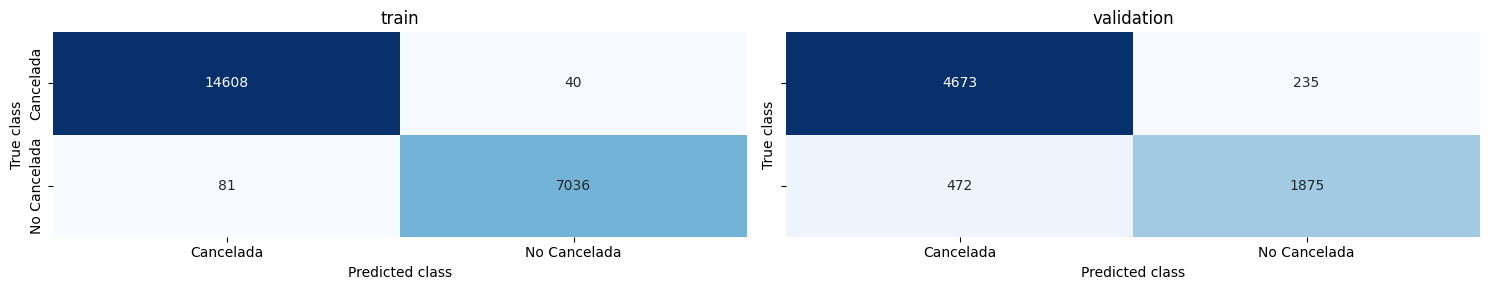

In [25]:
forest_model = RandomForestClassifier(random_state=10)

rf_model = Pipeline([
    ('mapper', mapper),
    ('classifier', forest_model),
])

rf_model.fit(train, train.booking_status)

evaluate_model(rf_model, title='Random Forest')

In [26]:
print('Cantidad de estimaciones base:', forest_model.n_estimators)
print('Profundidad máxima:', forest_model.max_depth)

Cantidad de estimaciones base: 100
Profundidad máxima: None


Se puede observar que el resultado del entrenamiento para Train es un overfitting, las métricas alcanzan un 99%. Al no definir ciertos parámetros cómo la cantidad de estimaciones base, cantidad máxima de features, profundidad máxima del árbol, éste se memoriza casos de ejemplo y termina sobreentrenando. 
Podemos observar que la cantidad de estimaciones base por defecto es 100. 

### Técnica para evitar overfitting en el modelo: 

- ### Definiendo hiperparámetros

Utilizamos **Grid Search** para encontrar los mejores valores para los hiperparámetros de n_estimators (cantidad de estimaciones base), max_depth (profundidad máxima del árbol), max_features (cantidad máxima de features a extraer). 

In [27]:
parameters = {'n_estimators': [100, 200], 
              'max_depth':[5, 10, 15, 20, 25],
              'max_features': [2, 5]}

clf = GridSearchCV(forest_model, parameters, refit=True, verbose=1)

gs_pipe = Pipeline([
    ('mapper', mapper),
    ('classifier', clf)
])

gs_pipe.fit(train, train.booking_status)

clf.best_score_, clf.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


(0.8954284401562141, {'max_depth': 20, 'max_features': 5, 'n_estimators': 200})

Utilizamos los hiperparámetros que nos devolvió Grid Search: 

'Random Forest con Grid Search'

,Precision,Recall,F1
train,0.95763,0.924125,0.940579
validation,0.88826,0.802727,0.843330


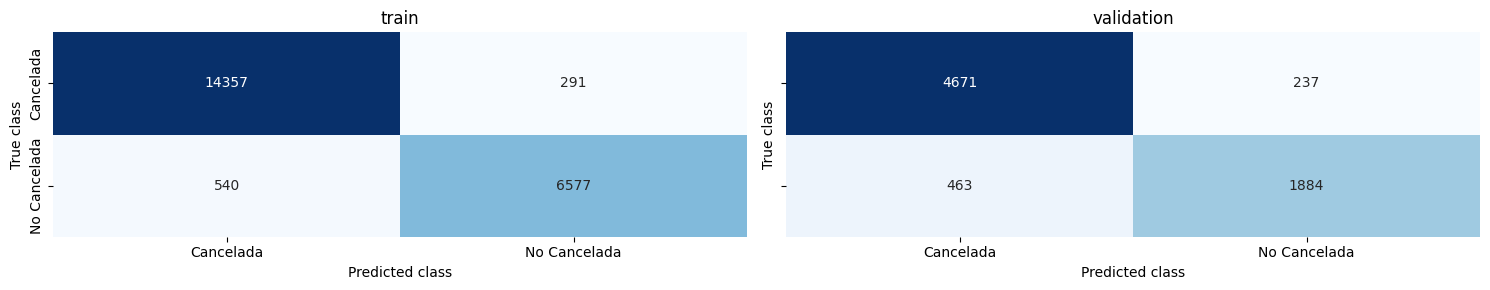

In [28]:
forest_model = RandomForestClassifier(n_estimators=200, max_depth=20, max_features=5)

rf_model = Pipeline([
    ('mapper', mapper),
    ('classifier', forest_model),
])

rf_model.fit(train, train.booking_status)

evaluate_model(rf_model, title='Random Forest con Grid Search')

Podemos observar que si utilizamos Grid Search para encontrar los mejores valores para los hiperparámetros, las métricas no llegan al 99%, por lo tanto se redujo el overfitting. En nuestro caso, al realizar Grid Search demora mucho en devolver los valores. Por lo tanto, decidimos definir de forma "manual" los valores para tratar de evitar el overfitting aún más. 

#### Ajuste de max_depth

Nos quedamos con los valores referidos a la cantidad de estimaciones base y de features que encontró Grid Search. Solamente ajustamos el valor de profundidad del árbol.

'Random Forest con valores óptimos'

,Precision,Recall,F1
train,0.882417,0.794014,0.835885
validation,0.879620,0.750320,0.809841


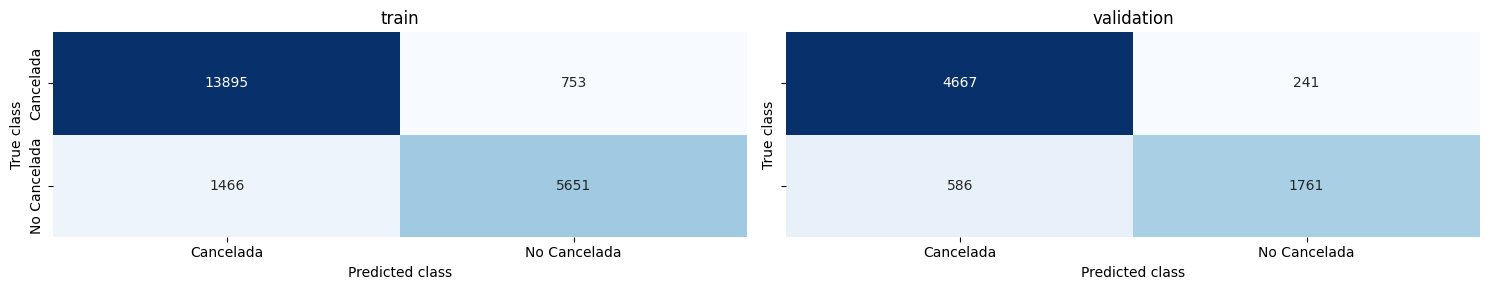

In [29]:
forest_model = RandomForestClassifier(n_estimators=200, max_depth=12, max_features=5)

rf_model = Pipeline([
    ('mapper', mapper),
    ('classifier', forest_model),
])

rf_model.fit(train, train.booking_status)

evaluate_model(rf_model, title='Random Forest con valores óptimos')

Reduciendo aún más la profundidad del árbol podemos ver que el modelo no está sobreentrando más, por lo tanto, pudimos resolver la problemática anterior. 

### Resumen y conclusiones sobre las técnicas para evitar sobreentrenamientos

Para los tres algoritmos que elegimos se le modificaron los hiperparámetros para encontrar el mejor valor para la métrica Precision, evitando overfitting. Estas modificaciones son las utilizadas para entrenar el resto de los modelos. 

- Para **Regresión Logística** decidimos modificarle la cantidad de iteraciones que hace el algoritmo, pudimos comprobar que limitando la cantidad a 13 iteraciones el modelo obtiene el mejor resultado para Precision. Valores menores a éste mantienen Precision, pero bajan los valores de Recall, por eso mismo dejamos el valor **máximo de iteraciones = 13**. Además decidimos balancear la clase minoritaria "Canceladas" y mayoritaria "No canceladas", los valores de Recall mejoran, pero baja Precision. Por eso, decidimos descartar esta alternativa. 

- Para **Decision Trees (Árboles de Decisión)** decidimos modificarle la profundidad máxima del árbol y el número mínimo de observaciones que debe tener una hoja para seguir creando nuevos nodos. Esto lo realizamos con **Grid Search**. Los valores asignados son: **profundidad máxima del árbol = 11** y **número mínimo de observaciones = 2**.  

- Para **Random Forests** decidimos utilizar **Grid Search** para encontrar los mejores valores para los hiperparámetros de n_estimators (cantidad de estimaciones base), max_depth (profundidad máxima del árbol), max_features (cantidad máxima de features a extraer). Los mejores valores encontrados son: **cantidad de estimaciones base = 200**, **profundidad máxima del árbol = 12**, **cantidad máxima de features a extrar = 5**

A continuación se muestra de manera gráfica la comparación de los diferentes valores para los hiperparámetros modificados de cada modelo, con respecto al valor de la métrica Precision:

In [30]:
def overfitting_test(model, set_names=('train', 'validation')):
    final_metrics = defaultdict(list)
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name]

        y = set_data.booking_status
        y_pred = model.predict(set_data)
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        
    return final_metrics


#### Regresión Logística

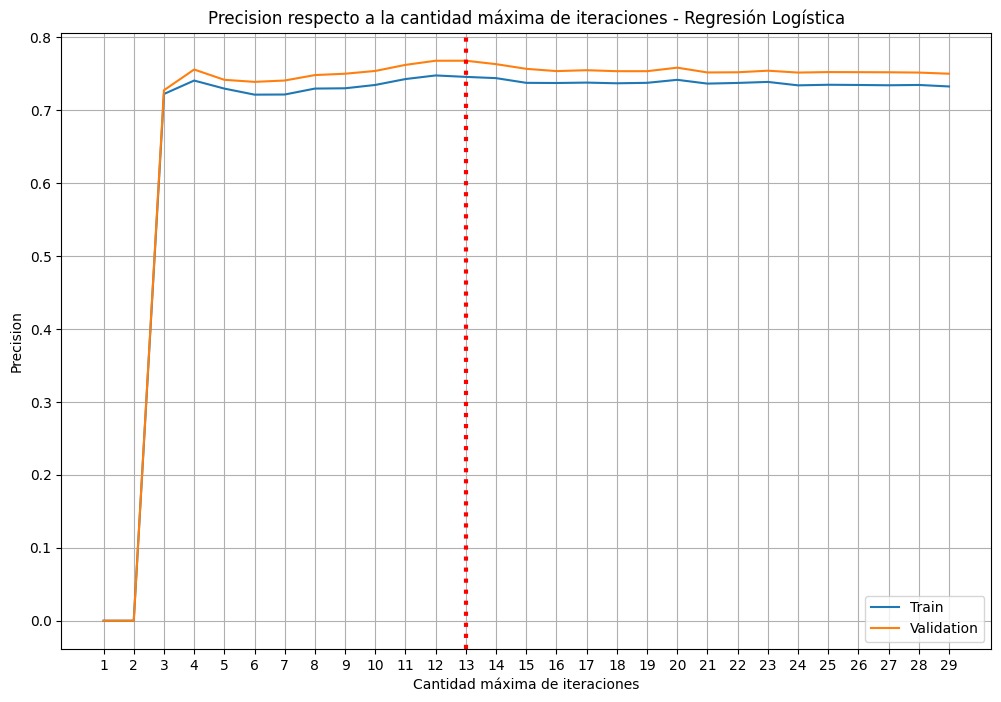

In [31]:
train_acc = []
validation_acc = []
for i in range(1,30):
    regression_model = LogisticRegression(max_iter=i, random_state=7)
    lr_model = Pipeline([
        ('mapper', mapper),
        ('classifier', regression_model),
    ])
    lr_model.fit(train, train.booking_status)

    final_metrics = overfitting_test(lr_model)
    train_acc.append(final_metrics['Precision'][0])
    validation_acc.append(final_metrics['Precision'][1])

plt.figure(figsize=(12,8))
plt.plot(train_acc, label='Train')
plt.plot(validation_acc, label='Validation')
plt.axvline(x=12, linewidth=3, color='red', linestyle=':')
plt.title('Precision respecto a la cantidad máxima de iteraciones - Regresión Logística')
plt.ylabel('Precision')
plt.xlabel('Cantidad máxima de iteraciones')
plt.xticks(np.arange(len(train_acc)), np.arange(1, len(train_acc)+1))
plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Decision Trees (Árboles de Decisión)

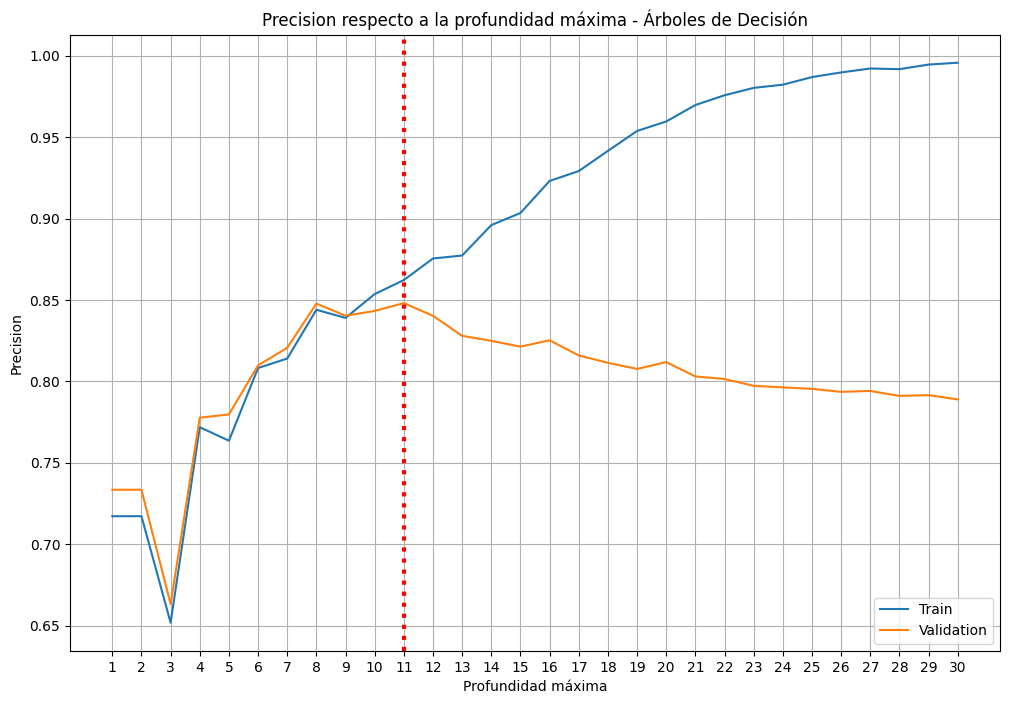

In [32]:
train_acc = []
validation_acc = []
for i in range(1,31):
    tree_model = DecisionTreeClassifier(max_depth=i, random_state=7)
    dt_model = Pipeline([
        ('mapper', mapper),
        ('classifier', tree_model),
    ])
    dt_model.fit(train, train.booking_status)

    final_metrics = overfitting_test(dt_model)
    train_acc.append(final_metrics['Precision'][0])
    validation_acc.append(final_metrics['Precision'][1])
    
plt.figure(figsize=(12,8))
plt.plot(train_acc, label='Train')
plt.plot(validation_acc, label='Validation')
plt.axvline(x=10, linewidth=3, color='red', linestyle=':')
plt.title('Precision respecto a la profundidad máxima - Árboles de Decisión')
plt.ylabel('Precision')
plt.xlabel('Profundidad máxima')
plt.xticks(np.arange(len(train_acc)), np.arange(1, len(train_acc)+1))
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Evaluación de los modelos con Feature Engineering aplicada.

#### 1. Regresión Logística - Parámetros por defecto

'Regresión Logistica con Feature Engineering'

,Precision,Recall,F1
train_fe,0.735887,0.615428,0.670288
validation_fe,0.755048,0.605454,0.672026


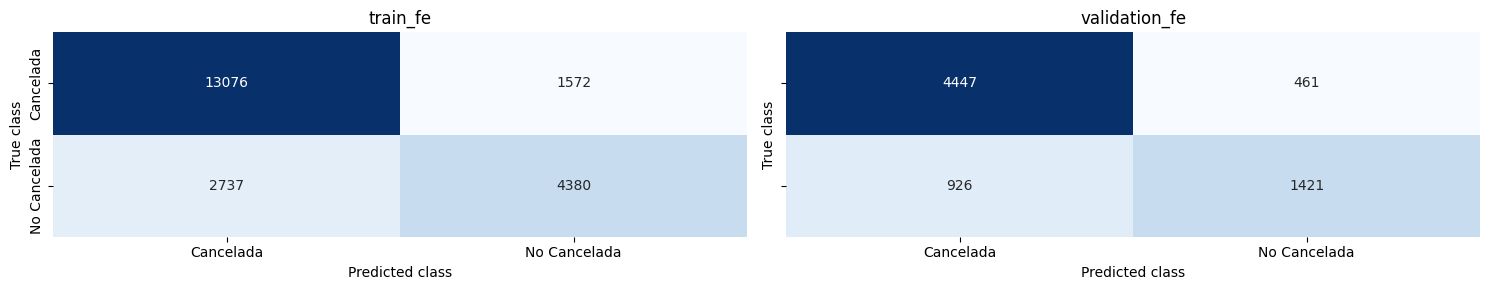

In [33]:
regression_model_fe = LogisticRegression(random_state=42)
lr_model_fe = Pipeline([
    ('mapper', mapper_fe),
    ('classifier', regression_model_fe)
])

lr_model_fe.fit(train_fe, train_fe.booking_status)
evaluate_model_fe(lr_model_fe, title='Regresión Logistica con Feature Engineering')

#### 2. Árboles de Decisión - Con límite de profundidad = 11

'Decision Tree con limite de profundidad = 11 y Feature Engineering'

,Precision,Recall,F1
train_fe,0.863818,0.818182,0.840381
validation_fe,0.843218,0.781423,0.811146


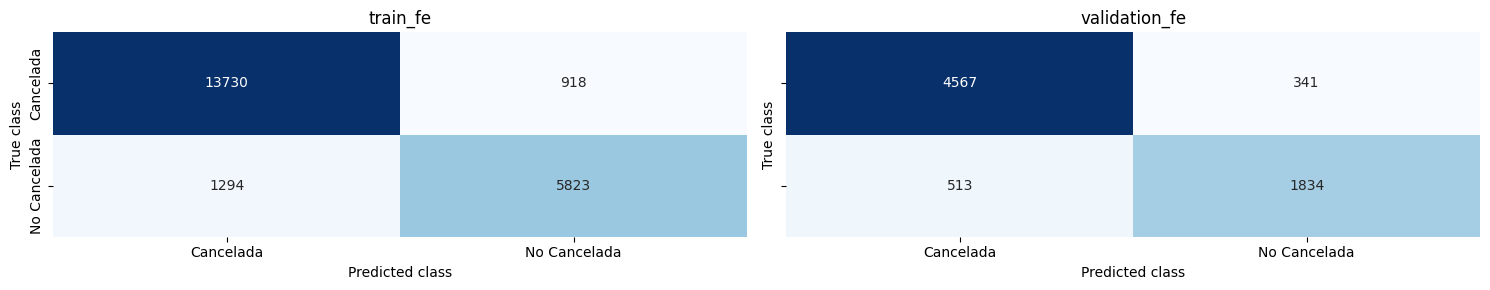

In [34]:
max_depth_value_fe = 11
min_samples_split_value_fe = 2
tree_model_fe = DecisionTreeClassifier(max_depth=max_depth_value_fe, min_samples_split=min_samples_split_value_fe, random_state=42)

dt_model_fe = Pipeline([
    ('mapper', mapper_fe),
    ('classifier', tree_model_fe),
])

dt_model_fe.fit(train_fe, train_fe.booking_status)

evaluate_model_fe(dt_model_fe, title='Decision Tree con limite de profundidad = 11 y Feature Engineering')

#### 3. Random Forests - Con n_estimators=200, max_depth=12, max_features=5.

'Random Forest con valores óptimos y Feature Engineering'

,Precision,Recall,F1
train_fe,0.894669,0.785303,0.836426
validation_fe,0.885554,0.741798,0.807327


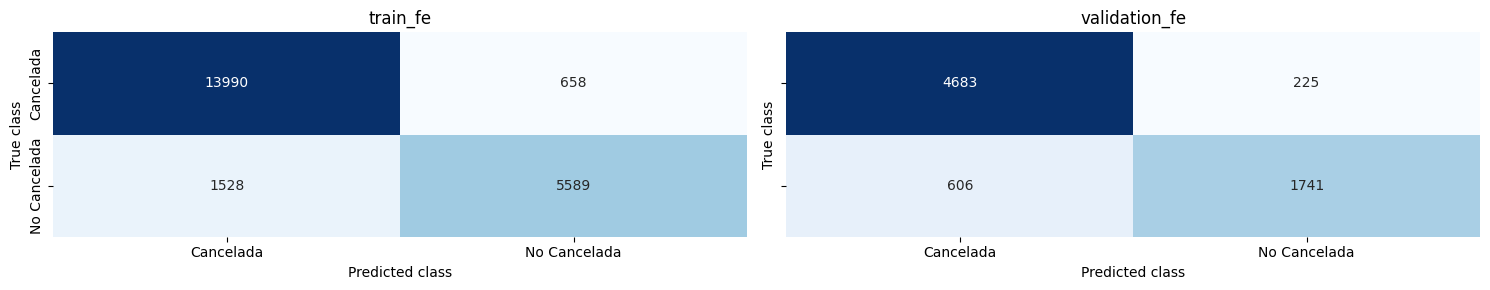

In [35]:
forest_model_fe = RandomForestClassifier(n_estimators=200, max_depth=12, max_features=5)

rf_model_fe = Pipeline([
    ('mapper', mapper_fe),
    ('classifier', forest_model_fe),
])

rf_model_fe.fit(train_fe, train_fe.booking_status)

evaluate_model_fe(rf_model_fe, title='Random Forest con valores óptimos y Feature Engineering')

### Comparación entre los modelos con y sin Feature Engineering

Luego de volver a entrenar los modelos elegidos con Feature Engineering y comparando con los entrenamientos anteriores, podemos ver que los resultados son muy similares. 
<br>
Se puede observar una leve mejora en la metrica de Precision para el modelo Random Forest con valores óptimos agregando Feature Engineering.
<br>
Esto podría darse debido a que las variables sobre las cual se genera la nueva columna no son muy influyentes en la variable target.

### Selección de un modelo y valor de la métrica a informar

El modelo seleccionado para informar al cliente es el de Random Forest con una cantidad de estimaciones base de 200, una profundidad máxima del árbol de 12 y una cantidad máxima de features a extraer de 5. Este modelo y los parametros fueron elegidos porque tuvo los mayores valores de Precision y menos diferencia entre los datos elegidos para train y validation, sin que se genere overfitting.
<br>
Para este caso donde buscamos predecir cuando resevar va a ser cancelada o no, decidimos informar la métrica de Precision. Ya que nos interesa saber de la cantidad clasificada como Foo cuantas realmente eran Foo.
<br>
El valor final a informar sería de un **87,6%** o de un 88,4% si incluimos la Feature de season generada. 